# Unit #3 Multiparameter models

The goal of this assignment is to conduct Bayesian inference on various multiparameter models.

## Problem #1 normal-inverse $\chi^2$

The Hubble data frame contains $3$ columns and $24$ rows. The columns are:

- `Galaxy`: A (factor) label identifying the galaxy.

- `y`: The galaxy's relative velocity in kilometres per second.

- `x`: The galaxy's distance in Mega parsecs. 1 parsec is 3.09e13 km.

For this problem, let's just single out `x`. Suppose that `x` is a vector of realizations from $X_1,...,X_{24} \overset{iid}{\sim} N(\mu, \sigma^2)$. Our goal will be to simulate from a joint posterior distribution over $(\mu, \sigma^2)$ given the data. Here's the data: 

In [1]:
library(LaplacesDemon)
hubble = read.table(url("https://raw.githubusercontent.com/bzaharatos/STAT-5630/main/hubble.txt"), sep = "\t")

n = length(hubble$x); 

#frequentist point estimates
var(hubble$x) 
mean(hubble$x)

[1] 33.81014

[1] 12.05458

In class, we showed that the joint posterior distribution for $(\mu, \sigma^2)$ is normal-inverse-$\chi^2$. We also wrote down the conditional distributions for $\mu \, | \, \sigma^2, \mathbf{x}$ and for $\sigma^2 \, | \, \mathbf{x}$. We can use these conditional distributions to sample from the joint posterior distribution:

1 Draw $\sigma^2$ from $\sigma^2 \, | \, \mathbf{x}$

2 Draw $\mu$ from $\mu \, | \, \sigma^2, \mathbf{x}$, where $\sigma^2$ is from step 1.

**Draw $m = 10,000$ samples from the joint posterior. Provide a histogram of the marginal distributions $\mu \, | \, \sigma^2,\mathbf{x}$ and $\sigma^2 \, | \, \mathbf{x}$.**

In [2]:
m = 10000
post = matrix(NA,nrow = m, ncol = 2)

for (i in 1:m){
    post[i,2] = rinvchisq(1, df = n-1, scale= var(hubble$x)) #posterior of sigma^2 | x
    post[i,1] = rnorm(1,mean(hubble$x),sqrt(post[i,2]/n)) #posterior | sigma^2 and x
}

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


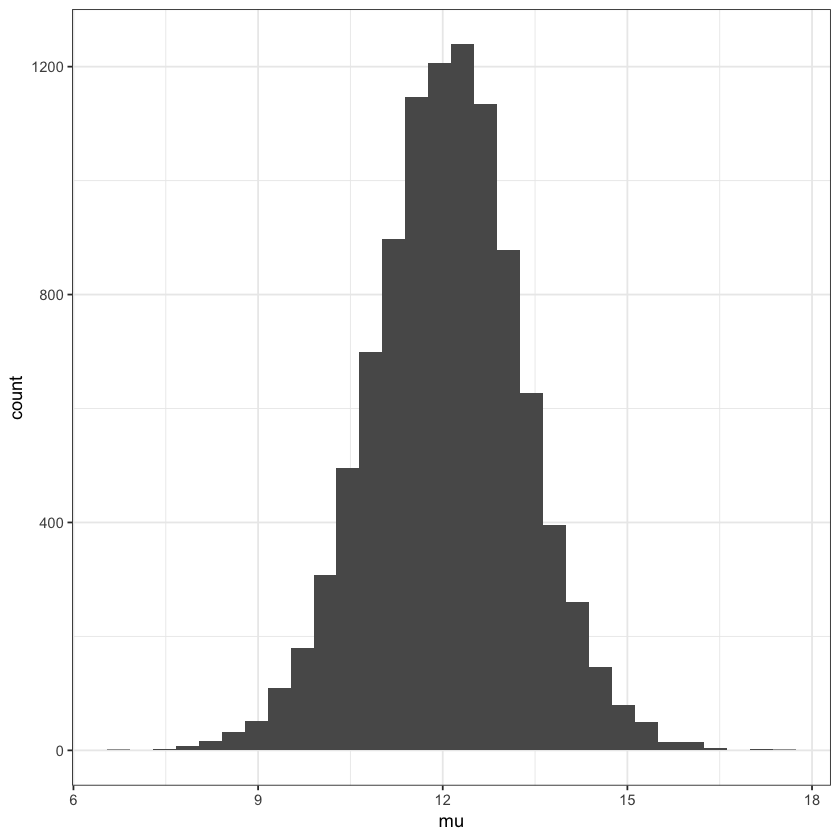

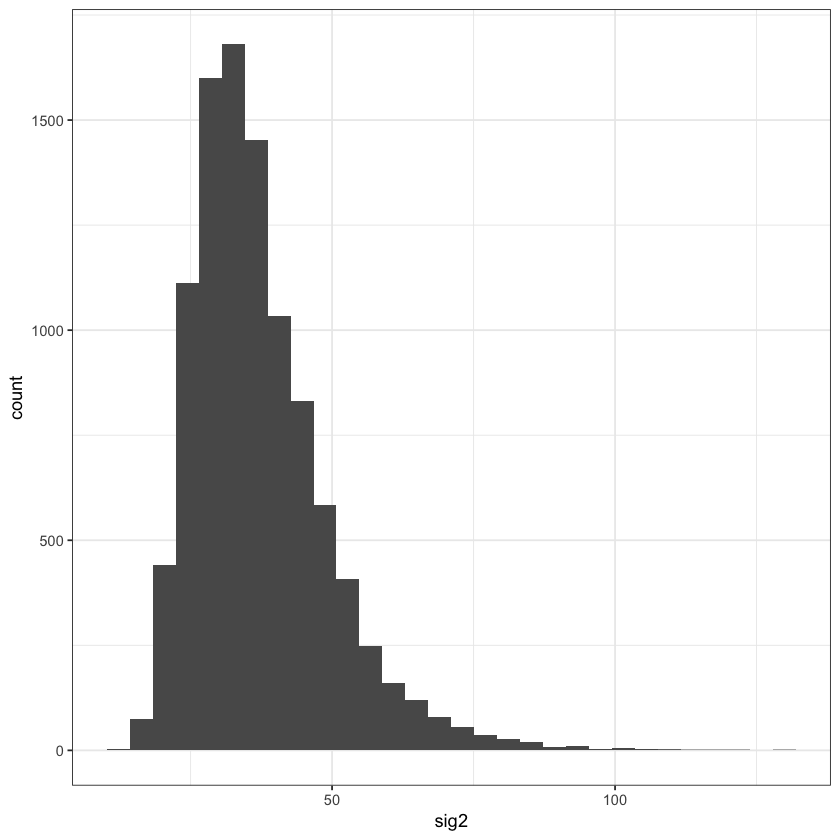

In [3]:
library(ggplot2)

df_plot = data.frame(mu = post[,1], sig2 = post[,2]); 
ggplot(df_plot) + 
    geom_histogram(aes(x = mu)) + 
    theme_bw()

ggplot(df_plot) + 
    geom_histogram(aes(x = sig2)) + 
    theme_bw()

## Problem #2 Drawing from the Wishart and multivariate normal distributions

Let's develop a multivariate normal random number generator! Suppose that $\Sigma_n$ is a symmetric positive definite matrix (as all variance-covariance matrices should be). Then we can construct a random draw from a multivariate normal distribution by using the Cholesky decomposition of $\Sigma_n$. 

Recall that the Choleksy decomposition of a positive definite matrix $\Sigma_n$ is given by $\Sigma_n = LL^T$, where $L$ is a lower triangular matrix.

**2 (a) Compute the Cholesky decomposition of the `sigma` below.**

In [4]:
n = 3
sigma = rbind(c(1,0.6,0.1), c(0.6,1, 0.3), 
              c(0.1,0.3,1)); 

In [5]:
U = chol(sigma); U
t(U)%*%U

1,0.6,0.1000000
0,0.8,0.3000000
0,0.0,0.9486833


1.0,0.6,0.1
0.6,1.0,0.3
0.1,0.3,1.0


Let $\mathbf{z} = (z_1,...,z_n)^T$ be $n$ independent draws from a (univariate) standard normal distribution. If $L$ is the lower triangular matrix obtained from the Cholesky decomposition, then $\theta = \mu + Lz$ is a random draw from the multivariate normal distribution with covariance matrix $\Sigma_n$.

**2 (b) Write a function that generates $m$ vectors from a multivariate normal distribution with mean vector `mu` and variance-covariance matrix `sigma`. Call your function `rmvn(m,mu,sigma)`.**

In [6]:
rmvn = function(m,mu,sigma){
    n = dim(sigma)[1]
    L = t(chol(sigma))
    theta = matrix(NA, nrow = n, ncol = m)
    for (i in 1:m){
        z = rnorm(n,0,1)
        theta[,i] = mu + L%*%z
    }
    return(theta)
}
sigma
rmvn(1,c(0,0,0), sigma)

1.0,0.6,0.1
0.6,1.0,0.3
0.1,0.3,1.0


1.4036766
1.7393248
0.3750225


You can use the multivariate normal distribution to generate random matrices from a Wishard distribution. First, simulate $\boldsymbol\theta_1,...,\boldsymbol\theta_v$ vectors, each of length $n$, from the multivariate normal distribution $N(\mathbf{0}, S)$ (be sure that $v > n - 1$). Then $$W = \sum^n_{i=1}\boldsymbol\theta_i\boldsymbol\theta_i^T,$$

will be from the Wishard distribution with degrees of freedom $v$ and positive definite matrix $S$.

**2 (c) Generate a random Wishard distributed matrix with $v = 3$ and $S$ from 1 (a).** 

In [7]:
v = 3; #degrees of freedom; should be greater than n
n = 3 #as above
rwish = function(v,n,S){
    alpha = matrix(NA, ncol = v, nrow = n)
    for (i in 1:v){
        alpha[,i] = rmvn(1,0,S); 
    }

    dim((alpha[,1]%*%t(alpha[,1])))
    W = matrix(0, ncol = n, nrow = n)

    for (i in 1:n){
        W = W + (alpha[,i]%*%t(alpha[,i]))
    }
    return(W)
    }


rwish(v,n,sigma)

0.8593507,1.288961,-0.844681
1.2889610,4.029340,1.303237
-0.8446810,1.303237,4.047091


## Problem #3 Bayesian Regression modeling in R 

The following dataset containts measurements related to the impact of three advertising medias on sales of a product, $P$. The variables are:

- `youtube`($\mathbf{x}_1$): the advertising budget allocated to YouTube. Measured in thousands of dollars;

- `facebook` ($\mathbf{x}_2$): the advertising budget allocated to Facebook. Measured in thousands of dollars; and 

- `newspaper`($\mathbf{x}_3$): the advertising budget allocated to a local newspaper. Measured in thousands of dollars.

- `sales`($\mathbf{Y}$): the value in the $i^{th}$ row of the sales column is a measurement of the sales (in thousands of units) for product $P$ for company $i$.

The advertising data treat "a company selling product $P$" as the statistical unit, and "all companies selling product $P$" as the population. We assume that the $n = 200$ companies in the dataset were chosen at random from the population (a strong assumption!).

In [8]:
library(ggplot2)

marketing = read.table(url("https://raw.githubusercontent.com/bzaharatos/-Statistical-Modeling-for-Data-Science-Applications/master/Modern%20Regression%20Analysis%20/Datasets/marketing.txt"), sep = "")

head(marketing)
n = dim(marketing)[1]; p = dim(marketing)[2] - 1

youtube,facebook,newspaper,sales
276.12,45.36,83.04,26.52
53.40,47.16,54.12,12.48
20.64,55.08,83.16,11.16
181.80,49.56,70.20,22.20
216.96,12.96,70.08,15.48
10.44,58.68,90.00,8.64


**3 (a) Center and scale the data so that the sample mean of each variable is zero and the sample variance is one.**

In [9]:
#scaling the data 
databar = colMeans(marketing)
XX = scale(marketing);
df = data.frame(XX); 
X = cbind(as.matrix(XX[,1:3])); p = dim(X)[2]; n = dim(X)[1];dim(X)
y = df$sales; 

[1] 200   3

**3 (b) Assume that $\mathbf{Y}\, | \, X, \boldsymbol\beta \sim N\left(X\boldsymbol\beta, \Sigma_n\right)$, where $\Sigma_n \propto I_n$. Compute the MLE of  $\boldsymbol\beta$, the residual sum of squares, and $\widehat{\sigma}^2 = \frac{RSS}{n-p}$.**

In [10]:
set.seed(111)

#MLE
b_ml = solve(t(X)%*%X)%*%t(X)%*%y; 
rss = sum((y - X%*%b_ml)^2)
sig2hat = rss/(n-p); sqrt(sig2hat)

lmod = lm(sales ~ .-1, data = df)
summary(lmod)

[1] 0.3222311


Call:
lm(formula = sales ~ . - 1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69195 -0.17074  0.04634  0.22795  0.54226 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
youtube    0.753066   0.022895  32.892   <2e-16 ***
facebook   0.536482   0.024442  21.949   <2e-16 ***
newspaper -0.004331   0.024444  -0.177     0.86    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3222 on 197 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 573.2 on 3 and 197 DF,  p-value: < 2.2e-16


**3 (c) Generate a random matrix that is symmetric positive definite with all entries close to zero. Call this matrix `Sigma_p` = $\Sigma_p$. Also, set `Sigma_n =` $\widehat{\sigma}^2I_n = \Sigma_n$.**

HINT: For a matrix $A$, the induced Gram matrix $A^TA$ is symmetric positive definite.

In [11]:
A = matrix(runif((p)^2,0,10), ncol=p) 
Sigma_p = t(A) %*% A; Sigma_p
Sigma_n = sig2hat*diag(1,ncol = n, nrow = n); 

101.66141,73.46667,55.31041
73.46667,58.27822,38.73052
55.31041,38.73052,47.02146


**3 (d) Assume that $\mathbf{Y}\, | \, X, \boldsymbol\beta \sim N\left(X\boldsymbol\beta, \Sigma_n\right)$, where $\Sigma_n \propto I_n$, and $\boldsymbol\beta \sim N(\beta_{ML}, \Sigma_p)$. Compute the posterior mean and variance-covariance matrix for $\boldsymbol\beta \, | \, \mathbf{Y}$.** 

In [12]:
#posterior
Sigma_beta = solve(t(X)%*%solve(Sigma_n)%*%X + solve(Sigma_p)); sqrt(sig2hat*diag(Sigma_beta))
mu_1 = (Sigma_beta)%*%(t(X)%*%solve(Sigma_n)%*%y + solve(Sigma_p)%*%b_ml); mu_1
summary(lmod)

youtube    facebook   newspaper 
0.007377165 0.007875457 0.007876571

youtube,0.753065912
facebook,0.536481550
newspaper,-0.004330686



Call:
lm(formula = sales ~ . - 1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.69195 -0.17074  0.04634  0.22795  0.54226 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
youtube    0.753066   0.022895  32.892   <2e-16 ***
facebook   0.536482   0.024442  21.949   <2e-16 ***
newspaper -0.004331   0.024444  -0.177     0.86    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3222 on 197 degrees of freedom
Multiple R-squared:  0.8972,	Adjusted R-squared:  0.8956 
F-statistic: 573.2 on 3 and 197 DF,  p-value: < 2.2e-16


**3 (e) Compare the mean and variance-covariance matrix of the posterior with frequentist MLE and standard error.**

In [13]:
coef(summary(lmod))[,1] - mu_1
sig2hat*solve(t(X)%*%X) - Sigma_beta

youtube,4.440892e-16
facebook,2.220446e-16
newspaper,-1.196959e-16


,youtube,facebook,newspaper
youtube,4.325353e-08,-4.601230e-08,1.200038e-09
facebook,-4.601230e-08,7.247734e-08,-2.470885e-08
newspaper,1.200038e-09,-2.470885e-08,2.634987e-08
